# Flow modelling – Altering flows

In [336]:
import graph_tool as gt
import graph_tool.draw
import graph_tool.search
import numpy as np
import datetime
import cairo

from collections import deque

In [307]:
print("Date:", datetime.datetime.now().date().isoformat())

Date: 2018-11-26


## Test data

Let's create an test graph that models cucumber production, packaging and consumption.

In [308]:
G = gt.Graph(directed=True)
G.load("cucumba.gt")

## Flow splitting

In the GDSE, flows have two properties, *mass* [tons] and *material composition* [fraction]. In order to compute stuff in the graph, the flows (edges) need to be split per material, often resulting in paralell edges.

In [309]:
def split_flows(G):
    """Split the flows based on material composition
    
    If a flow is composed of different materials, it is split into individual flows per material 
    with the corresponding mass.
    If the flow is composed of a single material, the composition property is removed and replaced with material.
    
    Returns
    -------
    graph
        The updated graph
    eprop_material
        Edge property (materials), string
    eprop_mass
        Edge property (mass), double
    vtx_mask
        Vertex property, bool
    """
    g = G.copy()
    g.clear_edges()
    del g.edge_properties['flow']
    eprops = G.edge_properties.keys()
    mass_list = []
    material_list = []
    assert 'flow' in eprops, "The graph must have 'flow' edge property"
    e_list = []
    for e in G.edges():
        prop = G.ep.flow[e]
        assert isinstance(prop, dict), "Edge property flow must be a dictionary in edge {}".format(e)
        for material, percent in prop['composition'].items():
            e_list.append(np.array([e.source(), e.target()], dtype=int))
            mass_list.append(float(prop['mass']) * float(percent))
            material_list.append(material)
    e_array = np.vstack(e_list)
    g.add_edge_list(e_array)
    eprop_mass = g.new_edge_property("float", vals=mass_list)
    eprop_mass_text = g.new_edge_property("string", vals=[round(i,2) for i in mass_list])
    eprop_material = g.new_edge_property("string", vals=material_list)
    r = (False for x in g.get_edges())
    edge_mask = g.new_edge_property("bool", vals=r)
    return (g, eprop_material, eprop_mass, eprop_mass_text, edge_mask)

In [370]:
g_split, eprop_material, eprop_mass, eprop_mass_text, visited = split_flows(G)

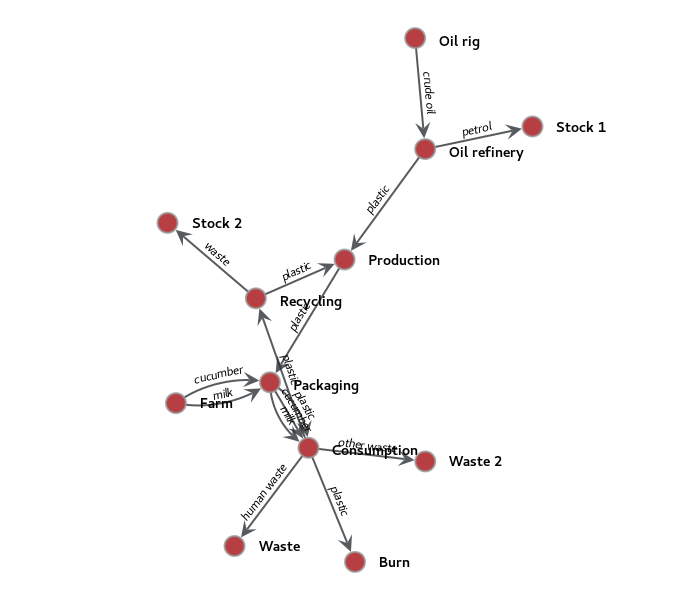

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f762a021780, at 0x7f7629cb8160>

In [311]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC},
                   edge_text=eprop_material,
                   output_size=(700,600), inline=True)

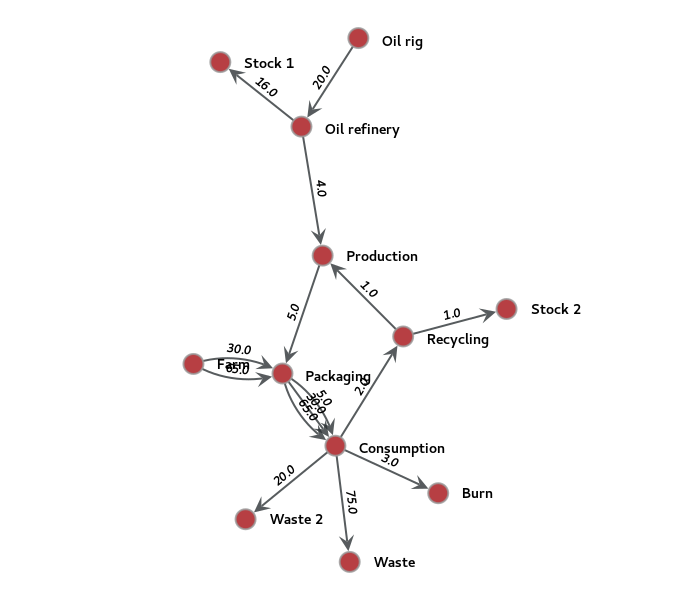

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f7629d14ef0, at 0x7f7629d15400>

In [372]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "text":eprop_mass_text, "font_weight": cairo.FONT_WEIGHT_BOLD},
                   output_size=(700,600), inline=True)

## Functions

In [313]:
def define_mask(g, eprop_material, materials):
    """Create an edge mask for the edges that contribute to the solution
    
    g - graph
    eprop_material - edge property map of the materials
    materials - list of strings, if an edge has a material in this list, the edge is included
    """
    cols = []
    mask = g.new_edge_property("bool")
    for i,e in enumerate(g.edges()):
        if eprop_material[e] in materials:
            mask[e] = True
            cols.append("green")
        else:
            mask[e] = False
            cols.append("red")
    
    return (mask, g.new_edge_property("string", vals=cols))

In [314]:
def compute_balancing_factor(sol_e, solution, eprop_mass):
    """Compute the balancing factor for a solution from a solution-edge
    
    sol_e - the solution edge (graph edge)
    solution - solution (float)
    eprop_mass - edge property map of masses
    """
    bf = abs(solution) / eprop_mass[sol_e]
    if bf < 1.0:
        balancing_factor = 1.0 - bf
    else:
        balancing_factor = bf
    return balancing_factor

In [315]:
def mass_balancer(g, eprop_mass, mask, sol_e, solution):
    g.clear_filters()
    balancing_factor = compute_balancing_factor(sol_e, solution, eprop_mass)
    eprop_mass_sol = eprop_mass.copy()
    eprop_mass_sol[sol_e] = eprop_mass[sol_e] * balancing_factor
    balancing_amount = ( eprop_mass[sol_e] * balancing_factor ) - eprop_mass[sol_e]

    for i,e in enumerate(g.edges()):
        if mask[e]:
            src = e.source()
            if src.in_degree() > 0:
                all_in = src.in_edges()
                all_out = src.out_edges()
                s = []
                f = []
                for ein in all_in:
                    s.append(eprop_mass[ein])
                    if mask[ein]:
                        f.append(eprop_mass[ein])
                sum_in = sum(s)
                flow = sum(f)
                sum_siblings_sol = sum([eprop_mass[out] for out in all_out if mask[out]]) # sum of mass of the siblings that belong the the solution
                portion_in = flow * (eprop_mass[e] / sum_siblings_sol) # portion of incoming mass in the current edge (solution edges only)
                portion_rest = eprop_mass[e] - portion_in # the rest of the flow which does not stem from the incoming solution edge
                new_mass = ( portion_in * balancing_factor ) + portion_rest
            else:
                new_mass = eprop_mass[e] + balancing_amount
            if new_mass <= eprop_mass[e]:
                eprop_mass_sol[e] = -1 * (eprop_mass[e] - new_mass)
            else:
                eprop_mass_sol[e] = new_mass - eprop_mass[e]       
        else:
            eprop_mass_sol[e] = 0
    
    return eprop_mass_sol

In [316]:
def flow_contribution(g, eprop_mass, mask, sol_e, solution):
    """Computes how much mass is accountable in the current edge to the mass in the solution edge"""
    g.clear_filters()
    eprop_mass_sol = eprop_mass.copy()
    
    for i,e in enumerate(g.edges()):
        if mask[e]:
            print(i,g.vp.id[e.source()], g.vp.id[e.target()])
            src = e.source()
            tgt = e.target()
            if tgt.in_degree() > 1:
                siblings_target = tgt.in_edges()
            if src.in_degree() > 0:
                all_in = src.in_edges()
                siblings_source = src.out_edges()
                s = []
                f = []
                for ein in all_in:
                    s.append(eprop_mass[ein])
                    if mask[ein]:
                        f.append(eprop_mass[ein])
                sum_in = sum(s)
                flow = sum(f)
                sum_siblings_src = sum([eprop_mass[out] for out in siblings_source if mask[out]]) # sum of mass of the siblings that belong the the solution
                sum_siblings_tgt = sum([eprop_mass[out] for out in siblings_target if mask[out]])
                sum_siblings_sol = sum_siblings_src + sum_siblings_tgt
                print("sum_siblings_sol", sum_siblings_sol)
                portion_in = flow * (eprop_mass[e] / sum_siblings_sol) # portion of incoming mass in the current edge (solution edges only)
                if portion_in > eprop_mass[e]:
                    print(i,g.vp.id[e.source()], g.vp.id[e.target()])
                    print("portion_in =", portion_in, "but mass on edge =",eprop_mass[e])
            else:
                portion_in = eprop_mass[e]
            eprop_mass_sol[e] = portion_in    
        else:
            eprop_mass_sol[e] = 0
    
    return eprop_mass_sol

In [317]:
def get_mass_change(g, eprop_mass, edge_mask, sol_e, solution):
    g.clear_filters()
    eprop_mass_sol = eprop_mass.copy()
    for i,e in enumerate(g.edges()):
        if edge_mask[e]:
            print(i,g_split.vp.id[e.source()], g_split.vp.id[e.target()])
            ratio = eprop_mass[e] / eprop_mass[sol_e]
            change = ratio * solution
            print("ratio", ratio)
            print("change", change)
            eprop_mass_sol[e] = change     
        else:
            eprop_mass_sol[e] = 0
    return eprop_mass_sol

In [357]:
def change_on_inflows(node, include, v, solution, mass):
    """Compute the mass change on each inflow for the node
    
    Returns
    -------
    tuple
        dict
            {edge : change}
        edge property map
            set to True for each visited edge
    """
    visited = v.copy()
    changes = {}
    if node.in_degree() > 0:
        all_in = list(node.in_edges())
        for i,e in enumerate(all_in):
            if include[e] and not visited[e]:
                # if the source of the inflow has outflows that are part of the solution def
                e_src = e.source()
                e_src_out = [e for e in e_src.out_edges() if include[e]]
                if len(e_src_out) > 1:
                    changes[e] = ( mass[e] / sum([mass[out_f] for out_f in e_src_out]) ) * solution
                else:
                    changes[e] = ( mass[e] / sum([mass[in_f] for in_f in all_in if include[in_f]]) ) * solution
                visited[e] = True
            else:
                pass
    else:
        print("source node,",node.vp.id)
    return (changes, visited)

In [438]:
class NodeVisitor(gt.search.BFSVisitor):

    def __init__(self, name, solution, mass, visited):
        self.id = name
        self.solution = solution
        self.mass = mass
        self.visited = visited
        assert "visited" in g_split.edge_properties

    def discover_vertex(self, u):
#        if not self.visited[e]:
#            print("-->", self.id[u], "has been discovered!")
        pass

    def examine_vertex(self, u):
        """Compute the mass change on each inflow for the node

        Returns
        -------
        dict
            {edge : change}
        """
        changes = {}
        if u.in_degree() > 0:
            all_in = list(u.in_edges())
            for i,e in enumerate(all_in):
                if not self.visited[e]:
                    e_src = e.source()
                    e_src_out = [e for e in e_src.out_edges()]
                    if len(e_src_out) > 1:
                        changes[e] = ( self.mass[e] / sum([self.mass[out_f] for out_f in e_src_out]) ) * self.solution
                    else:
                        changes[e] = ( self.mass[e] / sum([self.mass[in_f] for in_f in all_in]) ) * self.solution
                    print(self.id[e.source()], '-->', self.id[e.target()], changes[e])
                    self.visited[e] = True
        else:
            print("source node,", u.vp.id)
        return changes
        
def traverse_graph(g, edge, include, solution, mass, upstream=True):
    """Traverse the graph in a breadth-first-search manner
    
    Parameters
    ----------
    g : the graph to explore
    edge : the starting edge, normally this is the *solution edge*
    visited : edge propery map (bool) to indicate which edge have been visited
    include : edge propery map (bool) to indicate the edges that are part of the solution definition
    upstream : The direction of traversal. When upstream is True, the graph is explored upstream first, otherwise downstream first.  
    
    Returns
    -------
    None
    """
    r = (False for x in g.get_edges())
    visited = g.new_edge_property("bool", vals=r)
    if upstream:
        g.set_reversed(True)
    else:
        g.set_reversed(False)
    node = edge.target()
    g.set_edge_filter(include)
    print("\nTraversing in 1. direction")
    gt.search.bfs_search(g, node, NodeVisitor(name, solution, mass, visited))
    if g.is_reversed():
        g.set_reversed(False)
    else:
        g.set_reversed(True)
    print("\nTraversing in 2. direction")
    gt.search.bfs_search(g, node, NodeVisitor(name, solution, mass, visited))
    del visited
    g.set_reversed(False)
    g.clear_filters()

In [439]:
name = g_split.vp["id"]
traverse_graph(g_split, sol_e, edge_mask_1, solution, eprop_mass, upstream=True)


Traversing in 1. direction
Burn --> Consumption -0.18
Recycling --> Consumption -0.12
Consumption --> Packaging -0.3
Packaging --> Production -0.3
Production --> Oil refinery -0.24
Production --> Recycling -0.06
Oil refinery --> Oil rig -0.3

Traversing in 2. direction


In [394]:
g_split.edge_properties

{'eid': <PropertyMap object with key type 'Edge' and value type 'int32_t', for Graph 0x7f7629d14ef0, at 0x7f7629cef7f0>}

In [320]:
def plot_sol_mass(g, colors, mass):
    mass_text = g.new_edge_property("string", vals=[round(i,2) for i in mass])
    gt.draw.graph_draw(g, vertex_size=20, vertex_text=g.vp.id,
                       vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                       eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":colors},
                       edge_text=mass_text,
                       output_size=(700,600), inline=True)

In [321]:
def plot_sol_materials(g, colors, eprop_material):
    gt.draw.graph_draw(g, vertex_size=20, vertex_text=g.vp.id,
                       vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                       eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":colors},
                       edge_text=eprop_material,
                       output_size=(700,600), inline=True)

## Solution 1 – plastic reduction

*Reduce the amount of plastic between Packaging and Consumption by 20% in the part of the cucumber packaging* (blue edge)

In other words:

There are 30t of cucumbers (net), plus 5% over it in plastic, thus 1,5t of plastic, between Packaging and Consumption. The solution reduces the 1,5t by 20%, thus there will be only **1,2t** of plastic (blue arrow). As an effect, the plastic-related upstream and downstream flows need to change, but the *1,2t* will stay as set manually.

**solution**: the signed amount of change in mass on a particular flow

In [322]:
pe = g_split.edge(g_split.vertex(1), g_split.vertex(6), all_edges=True) # the 3 edges between Packaging and Cosumption
sol_e = [e for e in pe if eprop_material[e] == 'plastic'][0] # the specific edge (blue)

In [323]:
# Now we 'implement' the solution.
# The plastic flow contains the combined mass from cucumber and milk packaging, which is 5.0t. From the 5.0t, 1,5t was
# used for cucumbers as explained above. Now, the solution reduces the packaging of cucumbers by 0.3t
print("Current combined plastic mass after Packaging:", eprop_mass[sol_e])
solution = -0.3
print("Plastic mass after implementing the solution:", eprop_mass[sol_e] + solution)

Current combined plastic mass after Packaging: 5.0
Plastic mass after implementing the solution: 4.7


### Restricting the graph with the Solution

We need to restrict the graph to the flows that are involved in the *Solution*, otherwise flows might be altered that are not affected by the solution. For example, the solution affects the *Packaging* activity and reduces the amount of plastic packaging on cucumbers by 20%. Thus neither the amount of cucumbers nor the amount of milk should be changed.

Both the milk and cucumber *packaged product* consists of 5% plastic.

Thus the provided solution modfies the *green* edges and must not modify the *red* edges. The user is supposed to manually select the flows (green and blue edges) that are affected by the solution.

In [324]:
edge_mask_1, ecolors_1 = define_mask(g_split, eprop_material, ['plastic', 'crude oil'])

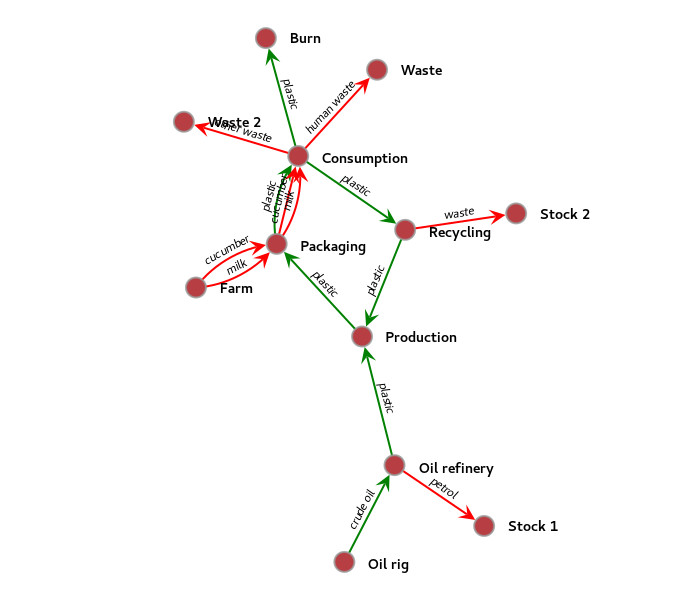

In [325]:
plot_sol_materials(g_split, ecolors_1, eprop_material)

In [331]:
g_split.set_reversed(True)

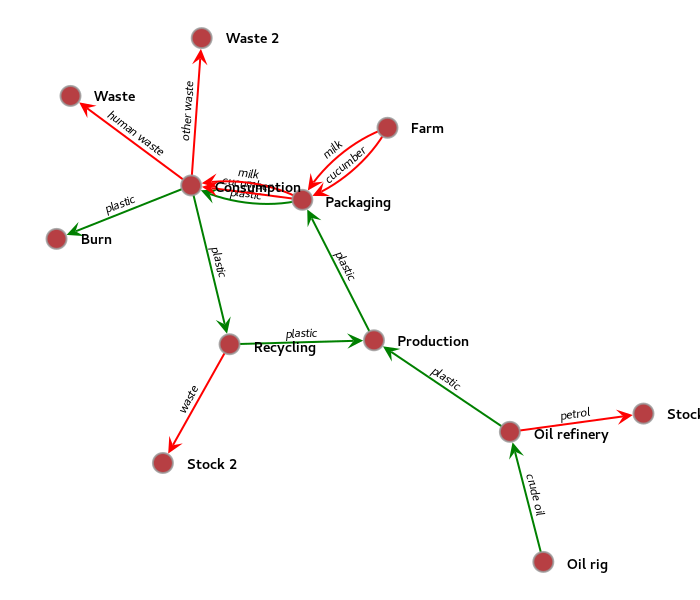

In [332]:
plot_sol_materials(g_split, ecolors_1, eprop_material)

In [ ]:
g_split.set_reversed(False)

#### Alternative 2

Compute $balancing\_factor=\frac{solution}{solution\_flow}$ , where *solution* is the amount in *t* by which the *Solution* modifies the *solution_flow* (the *plastic* between *Packaging* and *Consumption*)

Multiply each edge in the restricted graph by the *balancing_factor*

In [298]:
ch, v = change_on_inflows(g_split.vertex(5), edge_mask_1, visited, -0.3, eprop_mass)

In [299]:
for e in ch:
    print(g_split.vp.id[e.source()], '-->', g_split.vp.id[e.target()], ch[e])

Oil refinery --> Production -0.24
Recycling --> Production -0.06


In [205]:
mass_sol1 = get_mass_change(g_split, eprop_mass, edge_mask_1, sol_e, solution)
#mass_sol1 = mass_balancer(g_split, eprop_mass, edge_mask_1, sol_e, solution)

2 Packaging Consumption
ratio 1.0
change -0.3
5 Oil rig Oil refinery
ratio 4.0
change -1.2
7 Oil refinery Production
ratio 0.8
change -0.24
8 Production Packaging
ratio 1.0
change -0.3
10 Consumption Burn
ratio 0.6
change -0.18
11 Consumption Recycling
ratio 0.4
change -0.12
14 Recycling Production
ratio 0.2
change -0.06


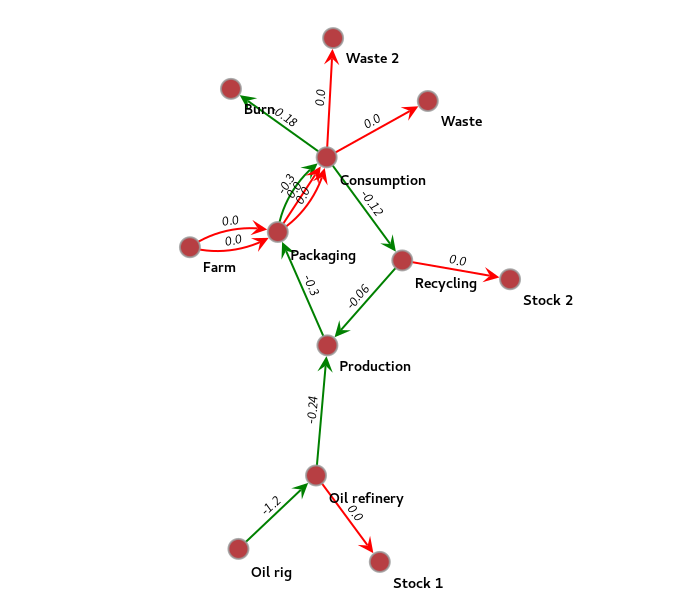

In [206]:
plot_sol_mass(g_split, ecolors_1, mass_sol1)

In [207]:
fcontrib_sol1 = flow_contribution(g_split, eprop_mass, edge_mask_1, sol_e, solution)

2 Packaging Consumption
sum_siblings_sol 10.0
5 Oil rig Oil refinery
7 Oil refinery Production
sum_siblings_sol 9.0
7 Oil refinery Production
portion_in = 8.88888888888889 but mass on edge = 4.0
8 Production Packaging
sum_siblings_sol 10.0
10 Consumption Burn
sum_siblings_sol 5.0
11 Consumption Recycling
sum_siblings_sol 5.0
14 Recycling Production
sum_siblings_sol 6.0


In [208]:
mass_sol1_f = get_mass_change(g_split, fcontrib_sol1, edge_mask_1, sol_e, solution)

2 Packaging Consumption
ratio 1.0
change -0.3
5 Oil rig Oil refinery
ratio 8.0
change -2.4
7 Oil refinery Production
ratio 3.555555555555556
change -1.0666666666666667
8 Production Packaging
ratio 1.0
change -0.3
10 Consumption Burn
ratio 1.2
change -0.36
11 Consumption Recycling
ratio 0.8
change -0.24
14 Recycling Production
ratio 0.13333333333333333
change -0.04


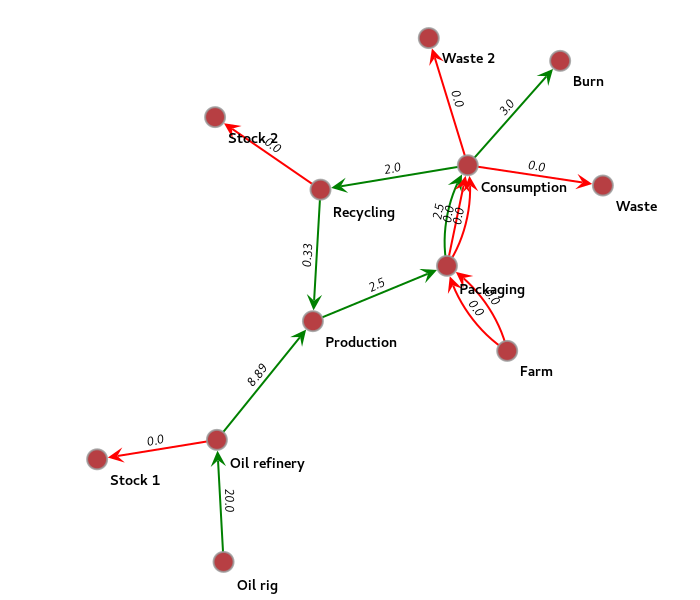

In [209]:
plot_sol_mass(g_split, ecolors_1, fcontrib_sol1)

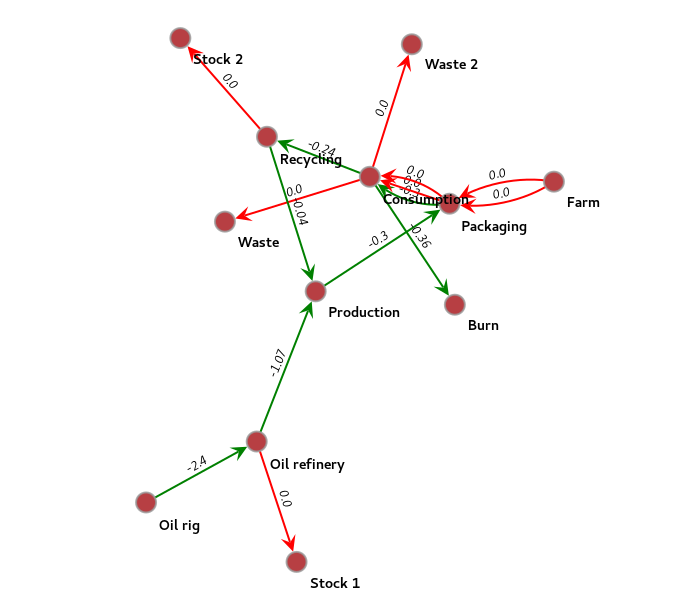

In [210]:
plot_sol_mass(g_split, ecolors_1, mass_sol1_f)

## Solution 2 – milk reduction

*Reduce milk production by 40%*

The current milk production is $0.6842*95=65t$ , after implementing the solution it will be reduced by 26t. Thus the __*balancing_factor* for milk is 0.6__.

Milk is also packaged in plastic, which is *5.4%* ( 3.5/65=0.054 ) over the net mass of the milk. Reducing the milk also reduces the plastic, thus at the end we'll end up with $(65t * 0.6) * 0.054 = 2.106t$ of plastic packaging for the milk. Thus the __*balancing_factor* for plastic is__ 2.106/3.5=__0.6017__ 

In [373]:
pe = g_split.edge(g_split.vertex(0), g_split.vertex(1), all_edges=True) # the 2 edges between Farm and Packaging
sol_e_2 = [e for e in pe if eprop_material[e] == 'milk'][0] # the specific edge (blue)
solution_2 = -26

print("Current milk mass after Farm", round(eprop_mass[sol_e_2],2))
print("Milk mass after implementing the solution", round(eprop_mass[sol_e_2] + solution_2,2))

Current milk mass after Farm 65.0
Milk mass after implementing the solution 39.0


The flows affected by the solution are manually selected by the user.

In [212]:
edge_mask_2, ecolors_2 = define_mask(g_split, eprop_material, ['milk', 'human waste', 'other waste'])

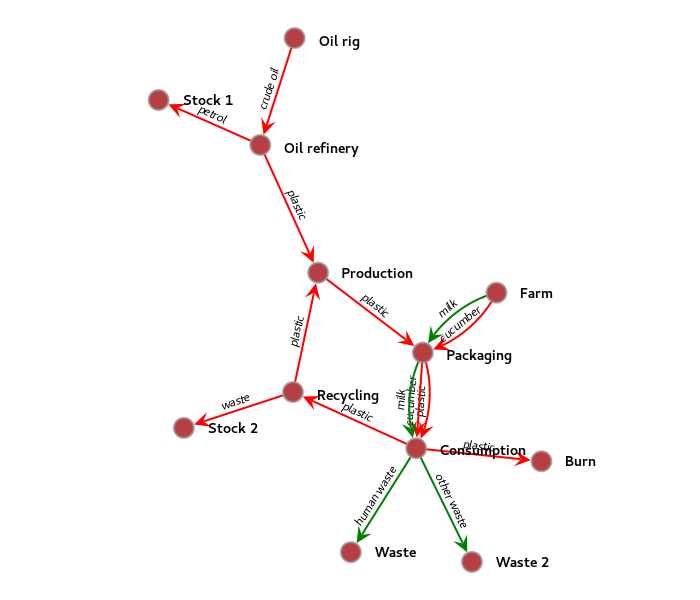

In [213]:
plot_sol_materials(g_split, ecolors_2, eprop_material)

The flow between *Consumption* and *Waste* has a different material (human waste, other waste) than milk. Because this flow (human waste, other waste) doesn't have a composition, we need to calcuate the ratio of milk in it.

### Computing the change in mass for flows


The goal of this step is to output the change in material mass after applying the solution to the system. In order to compute the change in mass for flows we need:

+ solution,

+ graph.

The **solution** is defined by:

+ the area to which is limited to

+ the **solution parts**, where each part is defined by:

    + *one* material, thus each solution part deals with only a single material
    
    + a **solution edge**, which is a single flow on which we apply the solution, eg. reduce the plastic in the Packaging-->Consumption flow
    
    + all the flows that are also affected by the solution, eg. all the connected flows that contain plastic (green arrows)
    
    + the order of computation

#### The algorithm
*sm*: the amount of mass on the solution edge

*solution*: the signed amount of change in mass on the solution edge

for each flow:

    if the flow is part of the solution:

        1. ratio = mass of the flow / sm

        2. change = ratio * solution
    
    else:
    
        1. change = 0

return *change* for each flow

#### Explanation of the algorithm
It is assumed that indeed all flows are selected in a solution part that are affected by the solution.



In [292]:
ch, v = change_on_inflows(g_split.vertex(11), edge_mask_2, visited, solution_2, eprop_mass)
for e in ch:
    print(g_split.vp.id[e.source()], '-->', g_split.vp.id[e.target()], ch[e])

Consumption --> Waste 2 -5.473684210526315


In [214]:
mass_sol2 = get_mass_change(g_split, eprop_mass, edge_mask_2, sol_e_2, solution_2)
#mass_sol2 = mass_balancer(g_split, eprop_mass, edge_mask_2, sol_e_2, solution_2)

1 Farm Packaging
ratio 1.0
change -26.0
4 Packaging Consumption
ratio 1.0000153848520745
change -26.00040000615394
9 Consumption Waste
ratio 1.1538639055985476
change -30.00046154556224
12 Consumption Waste 2
ratio 0.307697041492946
change -8.000123078816596


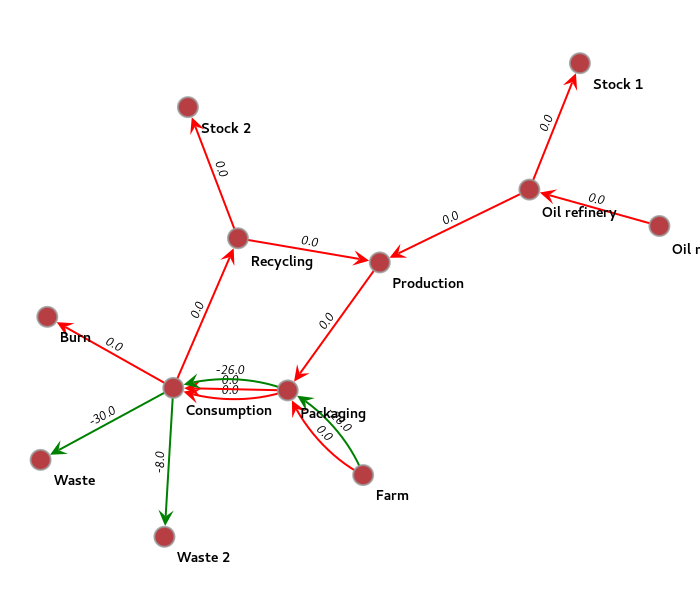

In [215]:
plot_sol_mass(g_split, ecolors_2, mass_sol2)

In [440]:
name = g_split.vp["id"]
traverse_graph(g_split, sol_e_2, edge_mask_2, solution_2, eprop_mass, upstream=True)


Traversing in 1. direction
Consumption --> Packaging -26.0
Packaging --> Farm -26.0

Traversing in 2. direction
Consumption --> Waste -20.526315789473685
Consumption --> Waste 2 -5.473684210526315


In [216]:
fcontrib_sol2 = flow_contribution(g_split, eprop_mass, edge_mask_2, sol_e_2, solution_2)

1 Farm Packaging
4 Packaging Consumption
sum_siblings_sol 130.0
9 Consumption Waste
sum_siblings_sol 95.0
12 Consumption Waste 2
sum_siblings_sol 95.0


In [217]:
mass_sol2_f = get_mass_change(g_split, fcontrib_sol2, edge_mask_2, sol_e_2, solution_2)

1 Farm Packaging
ratio 1.0
change -26.0
4 Packaging Consumption
ratio 0.5
change -13.0
9 Consumption Waste
ratio 0.7894858301463746
change -20.52663158380574
12 Consumption Waste 2
ratio 0.2105295547056999
change -5.473768422348197


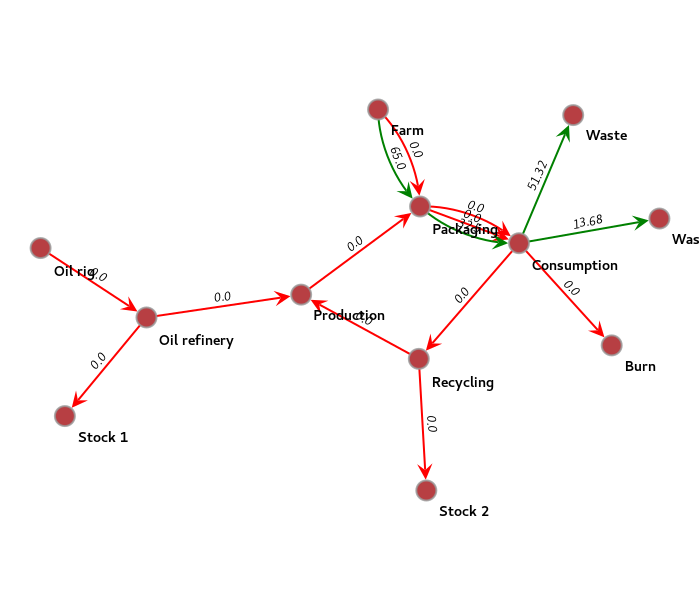

In [218]:
plot_sol_mass(g_split, ecolors_2, fcontrib_sol2)

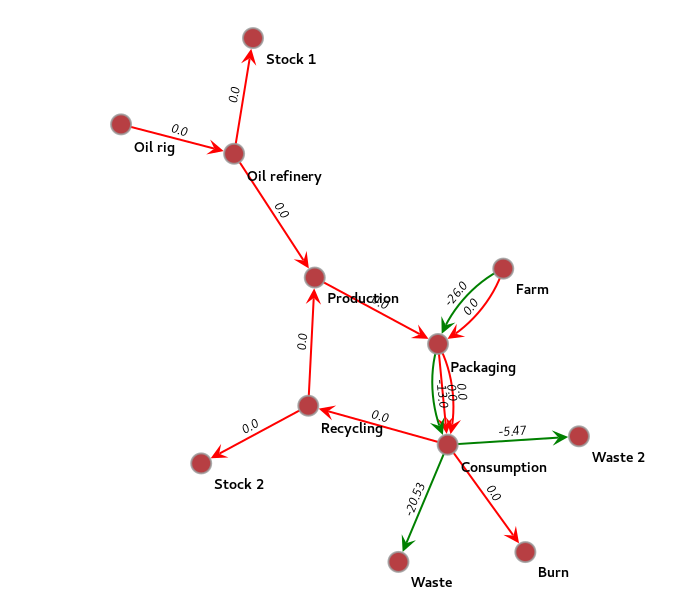

In [219]:
plot_sol_mass(g_split, ecolors_2, mass_sol2_f)

### Compute for the plastic part

Let's compute our expectation for the plastic reduction.

In [220]:
g_split.clear_filters() # remove the edge and vertex masks
pe = g_split.edge(g_split.vertex(1), g_split.vertex(6), all_edges=True) # the 3 edges between Packaging and Cosumption
sol_e_3 = [e for e in pe if eprop_material[e] == 'plastic'][0] # the specific edge (blue)
solution_3 = -0.6017 #Solution-2-–-milk-reduction

print("Current combined plastic mass after Packaging:", eprop_mass[sol_e_3])
print("Solution reduces the plastic mass by:", solution_3, "on the solution edge")
print("Plastic mass of the solution edge after implementing the solution:", round(eprop_mass[sol_e_3] + solution_3, 2))

Current combined plastic mass after Packaging: 5.0
Solution reduces the plastic mass by: -0.6017 on the solution edge
Plastic mass of the solution edge after implementing the solution: 4.4


In [221]:
edge_mask_3, ecolors_3 = define_mask(g_split, eprop_material, ['plastic', 'crude oil'])
mass_sol3 = get_mass_change(g_split, eprop_mass, edge_mask_3, sol_e_3, solution_3)
mass_sol3 = mass_balancer(g_split, eprop_mass, edge_mask_3, sol_e_3, solution_3)

2 Packaging Consumption
ratio 1.0
change -0.6017
5 Oil rig Oil refinery
ratio 4.0
change -2.4068
7 Oil refinery Production
ratio 0.8
change -0.48136
8 Production Packaging
ratio 1.0
change -0.6017
10 Consumption Burn
ratio 0.6
change -0.36102
11 Consumption Recycling
ratio 0.4
change -0.24068
14 Recycling Production
ratio 0.2
change -0.12034


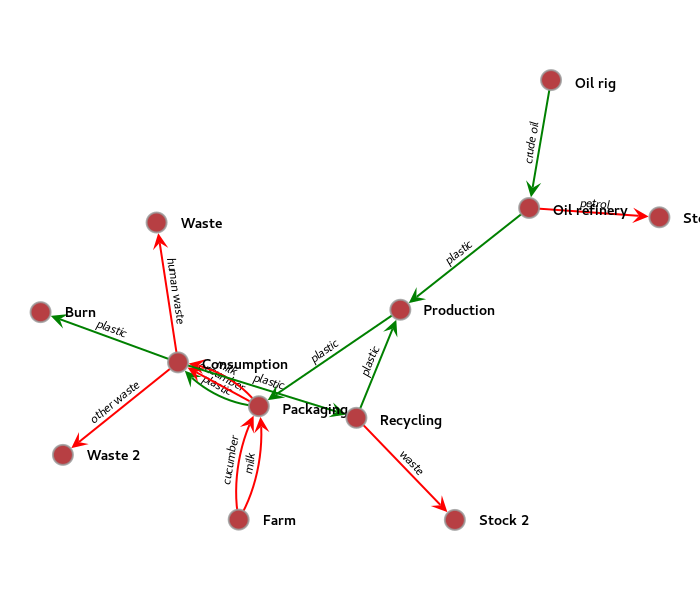

In [222]:
plot_sol_materials(g_split, ecolors_3, eprop_material)

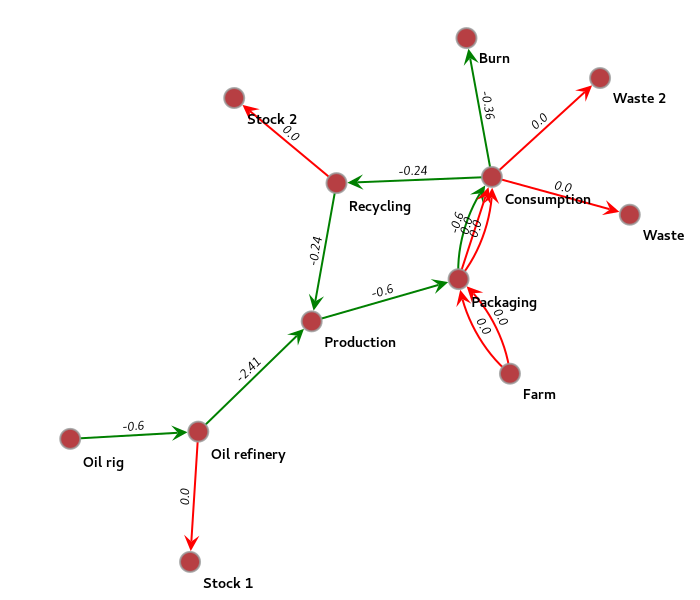

In [223]:
plot_sol_mass(g_split, ecolors_3, mass_sol3)

## Combining solutions or solution-parts

A **solution** is defined by
1. amount of change
2. affected material
3. the edge on which the solution is applied

**Solution-graph**: A subset of the graph/system containing only the edges that are affected by the solution and on which a solution has been already applied, thus the flows have been altered.

**Solution-part**: A solution can have several parts in case the desired change in a material results in changes in other materials. For example reducing the milk production also reduces the plastic production.

Once we computed the solution-parts for the milk and for the plastic, we need to integrate both into a single graph which then represents *the* complete solution. In a similar fashion, it should be possible to combine solutions that are part of a strategy.

The straightforward approach is to sum up the mass changes of each solution graph. In which case:

    for each edge:

        final mass = original mass + solution 1 + ... + solution n
        
But this requires that solution_n is the signed amount of change in mass for a particular edge, not the amount after applying the solution.

In [224]:
for i,e in enumerate(g_split.edges()):
    formula = "{eid}    {omass} + {s1}[mask {m1}] + {s2}[mask {m2}] + {s3}[mask {m3}] = {res}".format(
        eid=i, omass=eprop_mass[e],
        s1=round(mass_sol1[e],2), s2=round(mass_sol2[e],2), 
        s3=round(mass_sol3[e],2), m1=edge_mask_1[e], m2=edge_mask_2[e], m3=edge_mask_3[e],
        res=round(sum([eprop_mass[e], mass_sol1[e], mass_sol2[e], mass_sol3[e]]), 2)
    )
    print(formula)

0    30.001 + 0.0[mask 0] + 0.0[mask 0] + 0.0[mask 0] = 30.0
1    64.99900000000001 + 0.0[mask 0] + -26.0[mask 1] + 0.0[mask 0] = 39.0
2    5.0 + -0.3[mask 1] + 0.0[mask 0] + -0.6[mask 1] = 4.1
3    30.0 + 0.0[mask 0] + 0.0[mask 0] + 0.0[mask 0] = 30.0
4    65.0 + 0.0[mask 0] + -26.0[mask 1] + 0.0[mask 0] = 39.0
5    20.0 + -1.2[mask 1] + 0.0[mask 0] + -0.6[mask 1] = 18.2
6    16.0 + 0.0[mask 0] + 0.0[mask 0] + 0.0[mask 0] = 16.0
7    4.0 + -0.24[mask 1] + 0.0[mask 0] + -2.41[mask 1] = 1.35
8    5.0 + -0.3[mask 1] + 0.0[mask 0] + -0.6[mask 1] = 4.1
9    75.0 + 0.0[mask 0] + -30.0[mask 1] + 0.0[mask 0] = 45.0
10    3.0 + -0.18[mask 1] + 0.0[mask 0] + -0.36[mask 1] = 2.46
11    2.0 + -0.12[mask 1] + 0.0[mask 0] + -0.24[mask 1] = 1.64
12    20.0 + 0.0[mask 0] + -8.0[mask 1] + 0.0[mask 0] = 12.0
13    1.0 + 0.0[mask 0] + 0.0[mask 0] + 0.0[mask 0] = 1.0
14    1.0 + -0.06[mask 1] + 0.0[mask 0] + -0.24[mask 1] = 0.7


In [225]:
for i,e in enumerate(g_split.edges()):
    formula = "{eid}    {src} --> {dst}    change:  {ch}t  {mat}".format(
        eid=i, src=g_split.vp.id[e.source()], dst=g_split.vp.id[e.target()], mat=eprop_material[e], 
        ch=round(sum([mass_sol1[e],mass_sol2[e],mass_sol3[e]]), 2)
    )
    print("")
    print(formula)


0    Farm --> Packaging    change:  0.0t  cucumber

1    Farm --> Packaging    change:  -26.0t  milk

2    Packaging --> Consumption    change:  -0.9t  plastic

3    Packaging --> Consumption    change:  0.0t  cucumber

4    Packaging --> Consumption    change:  -26.0t  milk

5    Oil rig --> Oil refinery    change:  -1.8t  crude oil

6    Oil refinery --> Stock 1    change:  0.0t  petrol

7    Oil refinery --> Production    change:  -2.65t  plastic

8    Production --> Packaging    change:  -0.9t  plastic

9    Consumption --> Waste    change:  -30.0t  human waste

10    Consumption --> Burn    change:  -0.54t  plastic

11    Consumption --> Recycling    change:  -0.36t  plastic

12    Consumption --> Waste 2    change:  -8.0t  other waste

13    Recycling --> Stock 2    change:  0.0t  waste

14    Recycling --> Production    change:  -0.3t  plastic
